In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\astal\AppData\Local\Temp\ipykernel_11612\169947598.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constructor_data = current_constructors_pit_data_df[grouped_df['constructorId'] == constructor]
C:\Users\astal\AppData\Local\Temp\ipykernel_11612\169947598.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constructor_data = current_constructors_pit_data_df[grouped_df['constructorId'] == constructor]
C:\Users\astal\AppData\Local\Temp\ipykernel_11612\169947598.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constructor_data = current_constructors_pit_data_df[grouped_df['constructorId'] == constructor]
C:\Users\astal\AppData\Local\Temp\ipykernel_11612\169947598.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  constructor_data = current_constructors_pit_data_df[grouped_df['constructorId'] == constructor]
C:\Users\astal\AppData\Local\Temp\ip

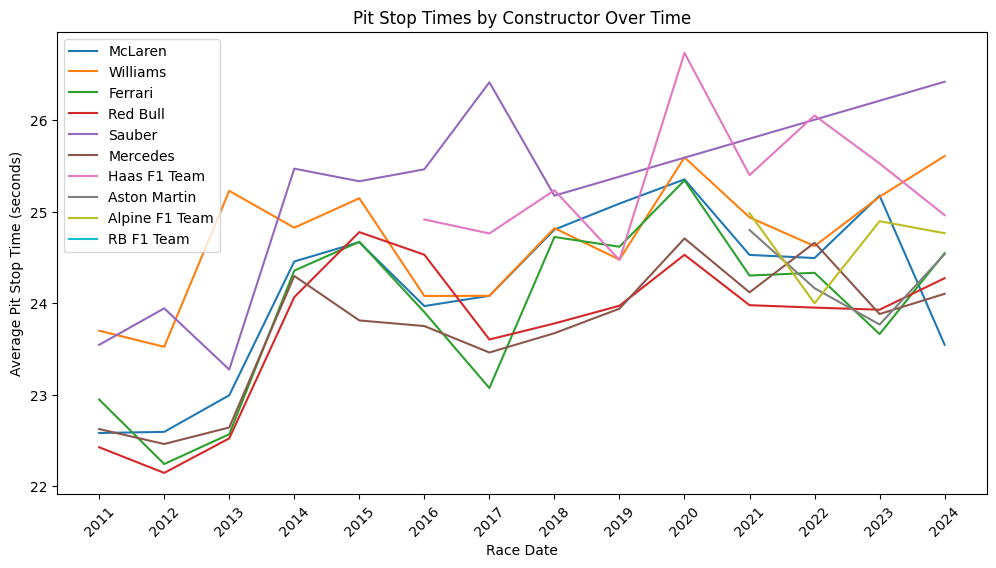

In [66]:
# Pit Stops df only contains data from the 2011 season
pit_stops_df = pd.read_csv('datasets/pit_stops.csv') # pit stop dataset
pit_stops_df['milliseconds'] = pit_stops_df['milliseconds'] / 1000 # convert to seconds
pit_stops_df = pit_stops_df[pit_stops_df['milliseconds'] < 50]
unique_race_ids = pit_stops_df['raceId'].unique() # unique race IDs

results_df = pd.read_csv('datasets/results.csv') # race results dataset
results_df = results_df[results_df['raceId'].isin(unique_race_ids)]
results_df.drop(columns=['resultId', 'number', 'positionText', 'position', 'positionOrder', 'points', 'laps', 'time', 'milliseconds', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId'], inplace=True)

constructors_df = pd.read_csv('datasets/constructors.csv') # constructors dataset
constructors_df.drop(columns=['nationality', 'constructorRef', 'url'], inplace=True)

races_df = pd.read_csv('datasets/races.csv') # races dataset
# needed to extract the race date for the time series
races_df = races_df[races_df['raceId'].isin(unique_race_ids)]
races_df = races_df[['raceId', 'year']]


merged_df = pd.merge(pit_stops_df, results_df, on=['raceId', 'driverId'], how='left')
merged_df = pd.merge(merged_df, races_df, on='raceId')

grouped_df = merged_df.groupby(['year', 'constructorId'])[['milliseconds']].mean().reset_index()
grouped_df = pd.merge(grouped_df, constructors_df, on='constructorId')



current_constructors = grouped_df[grouped_df['year'] == 2024]['constructorId']
current_constructors_pit_data_df = grouped_df[grouped_df['constructorId'].isin(current_constructors)]

plt.figure(figsize=(12, 6))

# Loop through each constructor and plot its pit stop times over races
for constructor in current_constructors_pit_data_df['constructorId'].unique():
    constructor_data = current_constructors_pit_data_df[grouped_df['constructorId'] == constructor]
    plt.plot(constructor_data['year'], constructor_data['milliseconds'], label=constructor_data['name'].iloc[0])

plt.xlabel('Race Date')
plt.ylabel('Average Pit Stop Time (seconds)')
plt.title('Pit Stop Times by Constructor Over Time')
plt.legend()

xticks_years = sorted(current_constructors_pit_data_df['year'].unique()) 
plt.xticks(xticks_years)
plt.xticks(rotation=45)
plt.show()

In [56]:

races_2021 = races_df[races_df['year'] == 2021]['raceId']
pit_stops_2021 = pit_stops_df[pit_stops_df['raceId'].isin(races_2021)]
pit_stops_2021[pit_stops_2021['milliseconds'] > 50]['raceId'].unique()

array([1053, 1055, 1057, 1061, 1062, 1072])